<a href="https://colab.research.google.com/github/mili189/ASK2026_Semiconductor_FDC/blob/main/%EA%B7%9C%EC%88%9C/%20TranAD/TranAD_1%EC%B0%A8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#1 드라이브 마운트 및 라이브러리 로드
from google.colab import drive
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
from tqdm import tqdm

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#2.데이터 로드 및 탐색 (EDA)
file_path = "/content/drive/MyDrive/Colab Notebooks/data set/MACHINE_data/MACHINE_Data.xlsx"
df = pd.read_excel(file_path)

meta_cols = ['Wafer_ID', 'Time_Step', 'Label', 'Fault_Type', 'Time', 'Step Number']
sensor_cols = df.columns.difference(meta_cols)
sensor_cols = df[sensor_cols].select_dtypes(include=[np.number]).columns.tolist()

print(f"로드 완료: {df.shape}, 센서 수: {len(sensor_cols)}")
for eid in ['l29', 'l31', 'l33']:
    print(f"실험 {eid} 데이터: {df['Wafer_ID'].str.contains(eid, case=False).sum()}개")

로드 완료: (12829, 25), 센서 수: 19
실험 l29 데이터: 4399개
실험 l31 데이터: 4180개
실험 l33 데이터: 4250개


In [ ]:
#3.데이터 전처리 및 저장 (논문 방식 정규화)
BASE_OUTPUT_FOLDER = './processed/LAM9600'
EXP_IDS = ['l29', 'l31', 'l33']

def normalize3(a, min_a=None, max_a=None):
    # TranAD 논문의 수식 (1)에 따른 정규화
    if min_a is None:
        min_a, max_a = np.min(a, axis=0), np.max(a, axis=0)
    # 분모 0 방지 상수 e'를 더함 [cite: 153]
    return (a - min_a) / (max_a - min_a + 0.0001), min_a, max_a

for eid in EXP_IDS:
    eid_df = df[df['Wafer_ID'].str.contains(eid, case=False, na=False)].copy()
    if len(eid_df) == 0: continue

    data_raw = eid_df[sensor_cols].values.astype(float)
    labels_raw = eid_df['Label'].apply(lambda x: 0 if str(x).strip().lower() == 'normal' else 1).values

    # [수정 포인트] 테스트 셋에 정상 데이터가 포함되도록 분할 지점 조정
    # 기존 0.8 대신 0.6 등으로 조정하거나, 첫 번째 이상치 발생 지점을 기준으로 분할
    anomaly_indices = np.where(labels_raw == 1)[0]
    if len(anomaly_indices) > 0:
        first_anomaly = anomaly_indices[0]
        # 첫 이상치 발생 200시점 전부터 테스트 셋으로 설정 (정상 구간 확보)
        split_idx = max(0, first_anomaly - 200)
    else:
        split_idx = int(len(data_raw) * 0.8)

    train_raw, test_raw = data_raw[:split_idx], data_raw[split_idx:]
    labels_test = labels_raw[split_idx:]

    # 전체 기간의 min, max를 기준으로 정규화 [cite: 152]
    _, min_v, max_v = normalize3(data_raw)
    train, _, _ = normalize3(train_raw, min_v, max_v)
    test, _, _ = normalize3(test_raw, min_v, max_v)

    # 실험별 폴더 생성 및 저장
    path = os.path.join(BASE_OUTPUT_FOLDER, eid)
    os.makedirs(path, exist_ok=True)

    np.save(f"{path}/train.npy", train)
    np.save(f"{path}/test.npy", test)
    # 진단(Diagnosis)을 위해 레이블을 차원 수만큼 확장 저장
    np.save(f"{path}/labels.npy", np.repeat(labels_test.reshape(-1, 1), test.shape[1], axis=1))

    print(f"실험 {eid} 전처리 완료: {path} (이상치 개수: {int(sum(labels_raw))}개)")

실험 l29 전처리 완료: ./processed/LAM9600/l29 (이상치 개수: 913개)
실험 l31 전처리 완료: ./processed/LAM9600/l31 (이상치 개수: 542개)
실험 l33 전처리 완료: ./processed/LAM9600/l33 (이상치 개수: 604개)


In [ ]:
#4. 모델 설계(TranAD)
import torch
import torch.nn as nn

def convert_to_windows(data, window_size=10):
    """
    데이터를 시계열 윈도우로 변환.
    윈도우 크기보다 작은 초기 데이터는 논문의 방식대로 복제 패딩을 적용함. [cite: 154, 157]
    """
    windows = []
    for i in range(len(data)):
        if i >= window_size:
            w = data[i-window_size:i]
        else:
            # 복제 패딩 (Replication Padding) 적용
            padding = data[0].repeat(window_size - i, 1)
            w = torch.cat([padding, data[0:i]])
        windows.append(w)
    return torch.stack(windows)

class TranAD(nn.Module):
    def __init__(self, feats):
        super(TranAD, self).__init__()
        self.name = 'TranAD'
        self.lr = 0.01
        self.n_window = 10
        self.n_feats = feats
        # 트랜스포머 인코더 및 디코더 정의 [cite: 201, 217]
        self.transformer = nn.Transformer(d_model=feats, nhead=feats, num_encoder_layers=1, num_decoder_layers=1)
        self.generator = nn.Sequential(nn.Linear(feats, feats), nn.Sigmoid())

    def forward(self, src, tgt):
        # 2단계 추론을 위한 순전파 로직 [cite: 263]
        out = self.transformer(src, tgt)
        return self.generator(out)

In [ ]:
#5. 학습 및 추론 루프
def train_model(model, loader, epochs=10):
    optimizer = torch.optim.AdamW(model.parameters(), lr=model.lr)
    l = nn.MSELoss(reduction='none')

    model.train()
    for epoch in range(epochs):
        loss_list = []
        for d, _ in loader:
            # 배치 크기 차원 정렬 (Window_size, Batch, Feats) [cite: 225]
            window = d.permute(1, 0, 2)
            # 타겟은 윈도우의 가장 마지막 시점 데이터
            elem = window[-1, :, :].view(1, d.shape[0], model.n_feats)

            z = model(window, elem)

            # 논문의 두 단계 손실 함수 중 기본 재구성 손실 적용 [cite: 284, 321]
            l1 = torch.mean(l(z, elem))
            loss_list.append(l1.item())

            optimizer.zero_grad()
            l1.backward()
            optimizer.step()
        print(f"Epoch {epoch} Loss: {np.mean(loss_list):.6f}")

results_data = {}
for eid in EXP_IDS:
    # 데이터 로드
    train_data = np.load(f"{BASE_OUTPUT_FOLDER}/{eid}/train.npy")
    test_data = np.load(f"{BASE_OUTPUT_FOLDER}/{eid}/test.npy")
    labels = np.load(f"{BASE_OUTPUT_FOLDER}/{eid}/labels.npy")
    labels_flat = (np.sum(labels, axis=1) >= 1).astype(int)

    # 텐서 변환 및 윈도우 생성 [cite: 154, 157]
    train_ts = torch.DoubleTensor(train_data)
    test_ts = torch.DoubleTensor(test_data)
    train_win = convert_to_windows(train_ts)
    test_win = convert_to_windows(test_ts)

    # 모델 초기화 및 학습
    model = TranAD(train_data.shape[1]).double()
    # 배치 학습을 통해 학습 속도 향상 [cite: 225]
    train_loader = DataLoader(TensorDataset(train_win, train_win), batch_size=128, shuffle=True)

    print(f"\n>>> 실험 {eid} 학습 시작")
    train_model(model, train_loader, epochs=10)

    # 추론 단계 (Inference) [cite: 352]
    model.eval()
    with torch.no_grad():
        # [수정] 테스트 전체 데이터를 한 번에 처리하기 위해 배치 크기 일치
        test_batch_size = test_win.shape[0]
        w = test_win.permute(1, 0, 2)
        # tgt(e)의 배치를 src(w)의 배치와 동일하게 맞춤 (1 -> test_batch_size)
        e = test_win[:, -1, :].view(1, test_batch_size, model.n_feats)

        z = model(w, e)
        # 결과값 추출 (Batch, Feats)
        y_pred = z.detach().cpu().numpy()[0]

        # 이상 점수 계산: 실제 값과 재구성 값의 차이 [cite: 195, 349]
        mse = np.mean((y_pred - test_data)**2, axis=1)

        # 임계값 설정을 위한 학습 데이터 오차 계산 [cite: 195, 354]
        train_batch_size = train_win.shape[0]
        tw = train_win.permute(1, 0, 2)
        te = train_win[:, -1, :].view(1, train_batch_size, model.n_feats)
        tz = model(tw, te)
        train_mse = np.mean((tz.detach().cpu().numpy()[0] - train_data)**2, axis=1)

    results_data[eid] = {
        'mse': mse,
        'train_mse': train_mse,
        'labels': labels_flat,
        'test_data': test_data,
        'y_pred': y_pred
    }
    print(f"실험 {eid} 추론 완료.")


>>> 실험 l29 학습 시작


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 0 Loss: 0.023498
Epoch 1 Loss: 0.015053
Epoch 2 Loss: 0.009112
Epoch 3 Loss: 0.006462
Epoch 4 Loss: 0.004804
Epoch 5 Loss: 0.003794
Epoch 6 Loss: 0.003140
Epoch 7 Loss: 0.002722
Epoch 8 Loss: 0.002434
Epoch 9 Loss: 0.002202
실험 l29 추론 완료.

>>> 실험 l31 학습 시작
Epoch 0 Loss: 0.025769
Epoch 1 Loss: 0.014424
Epoch 2 Loss: 0.008769
Epoch 3 Loss: 0.006186
Epoch 4 Loss: 0.004872
Epoch 5 Loss: 0.003981
Epoch 6 Loss: 0.003367
Epoch 7 Loss: 0.002941
Epoch 8 Loss: 0.002740
Epoch 9 Loss: 0.002473
실험 l31 추론 완료.

>>> 실험 l33 학습 시작
Epoch 0 Loss: 0.025698
Epoch 1 Loss: 0.011832
Epoch 2 Loss: 0.007734
Epoch 3 Loss: 0.005754
Epoch 4 Loss: 0.004471
Epoch 5 Loss: 0.003950
Epoch 6 Loss: 0.003500
Epoch 7 Loss: 0.003180
Epoch 8 Loss: 0.002958
Epoch 9 Loss: 0.002822
실험 l33 추론 완료.


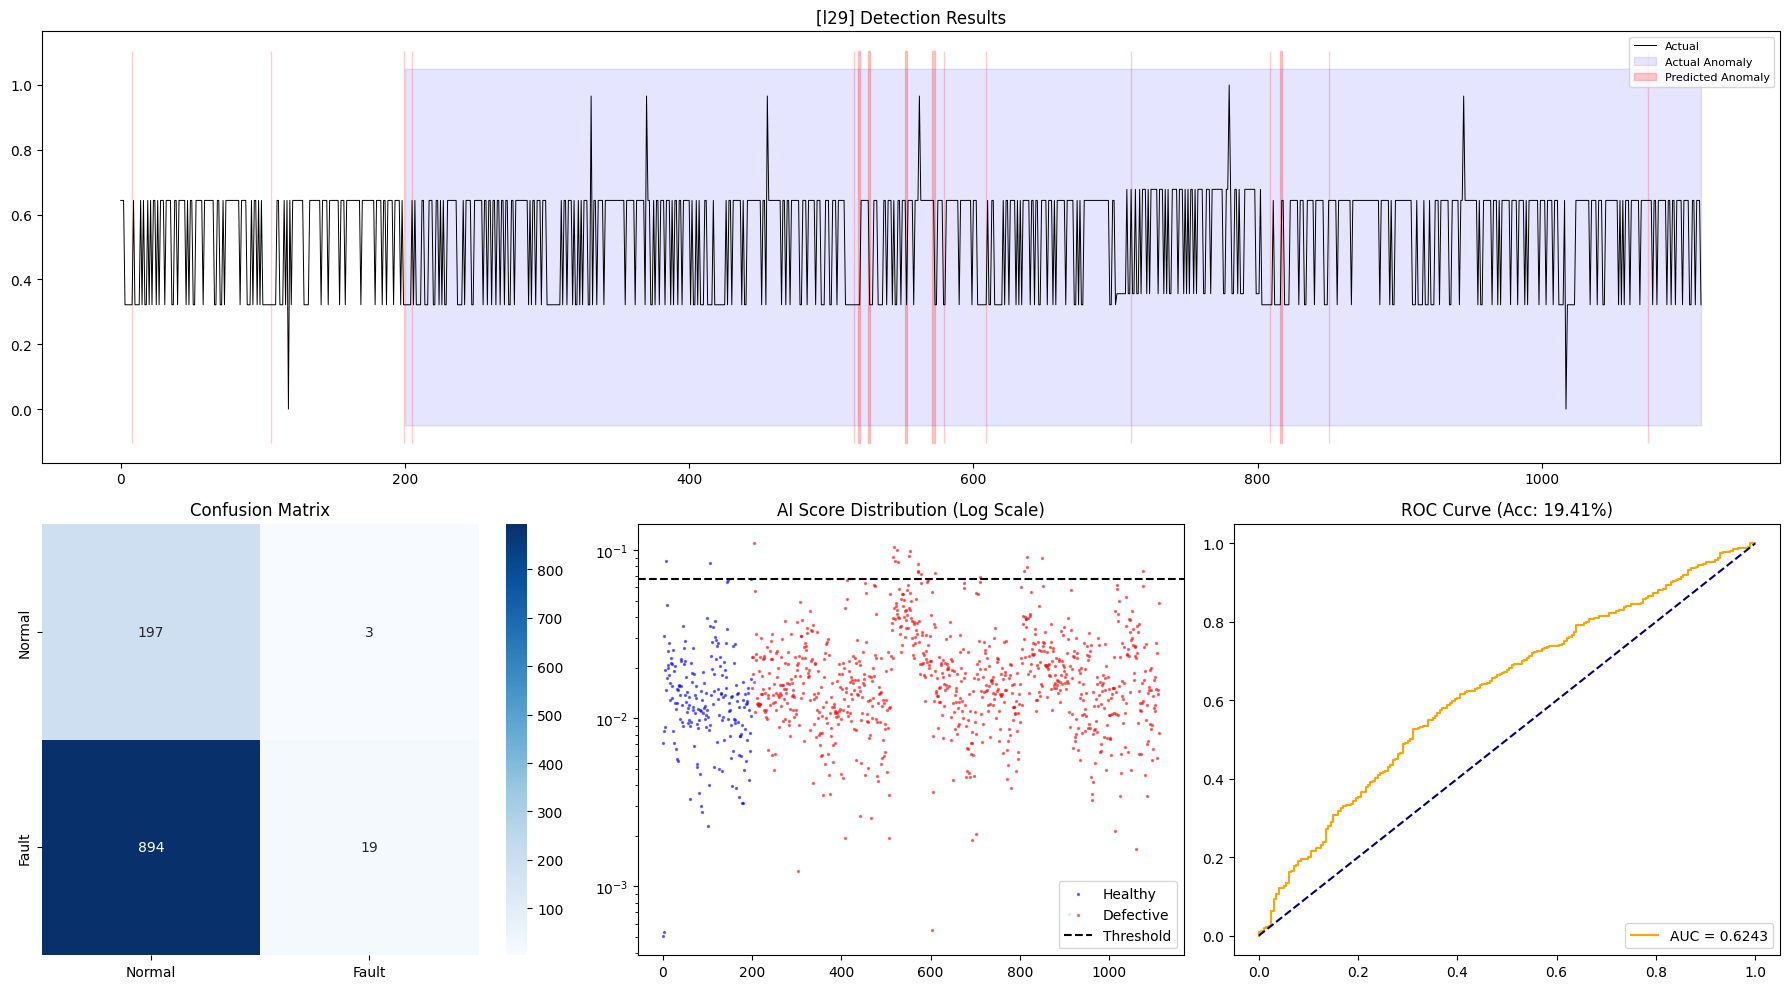

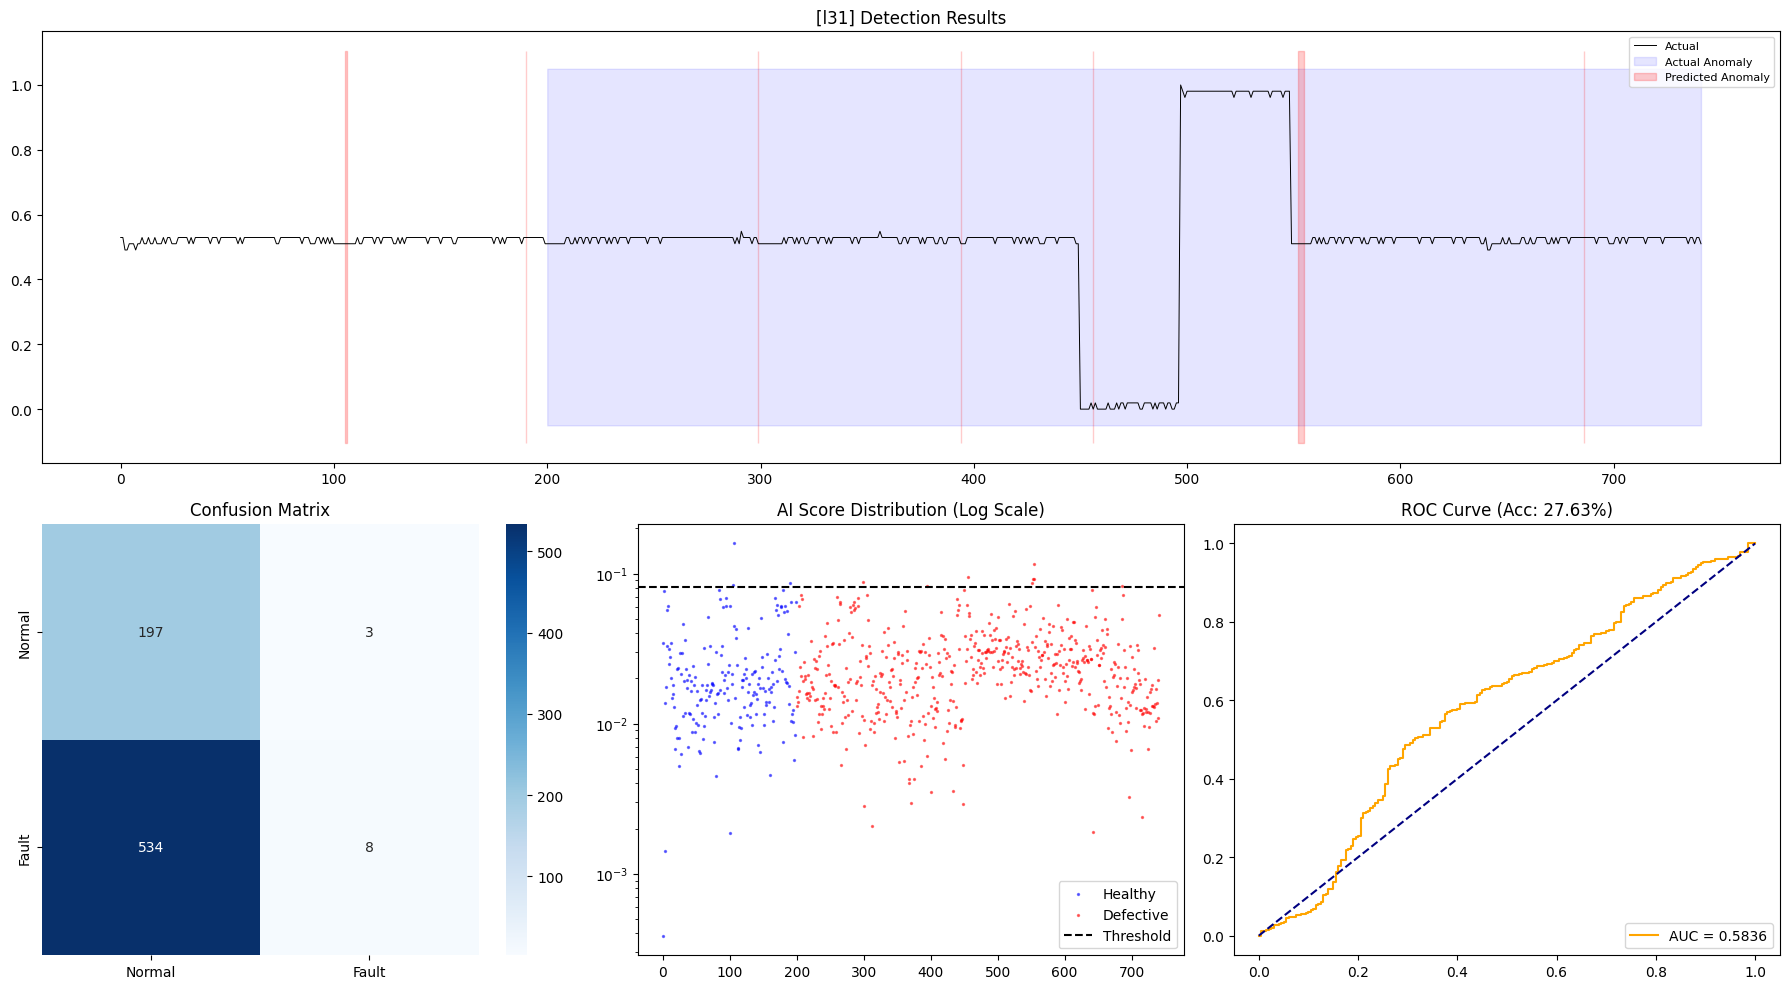

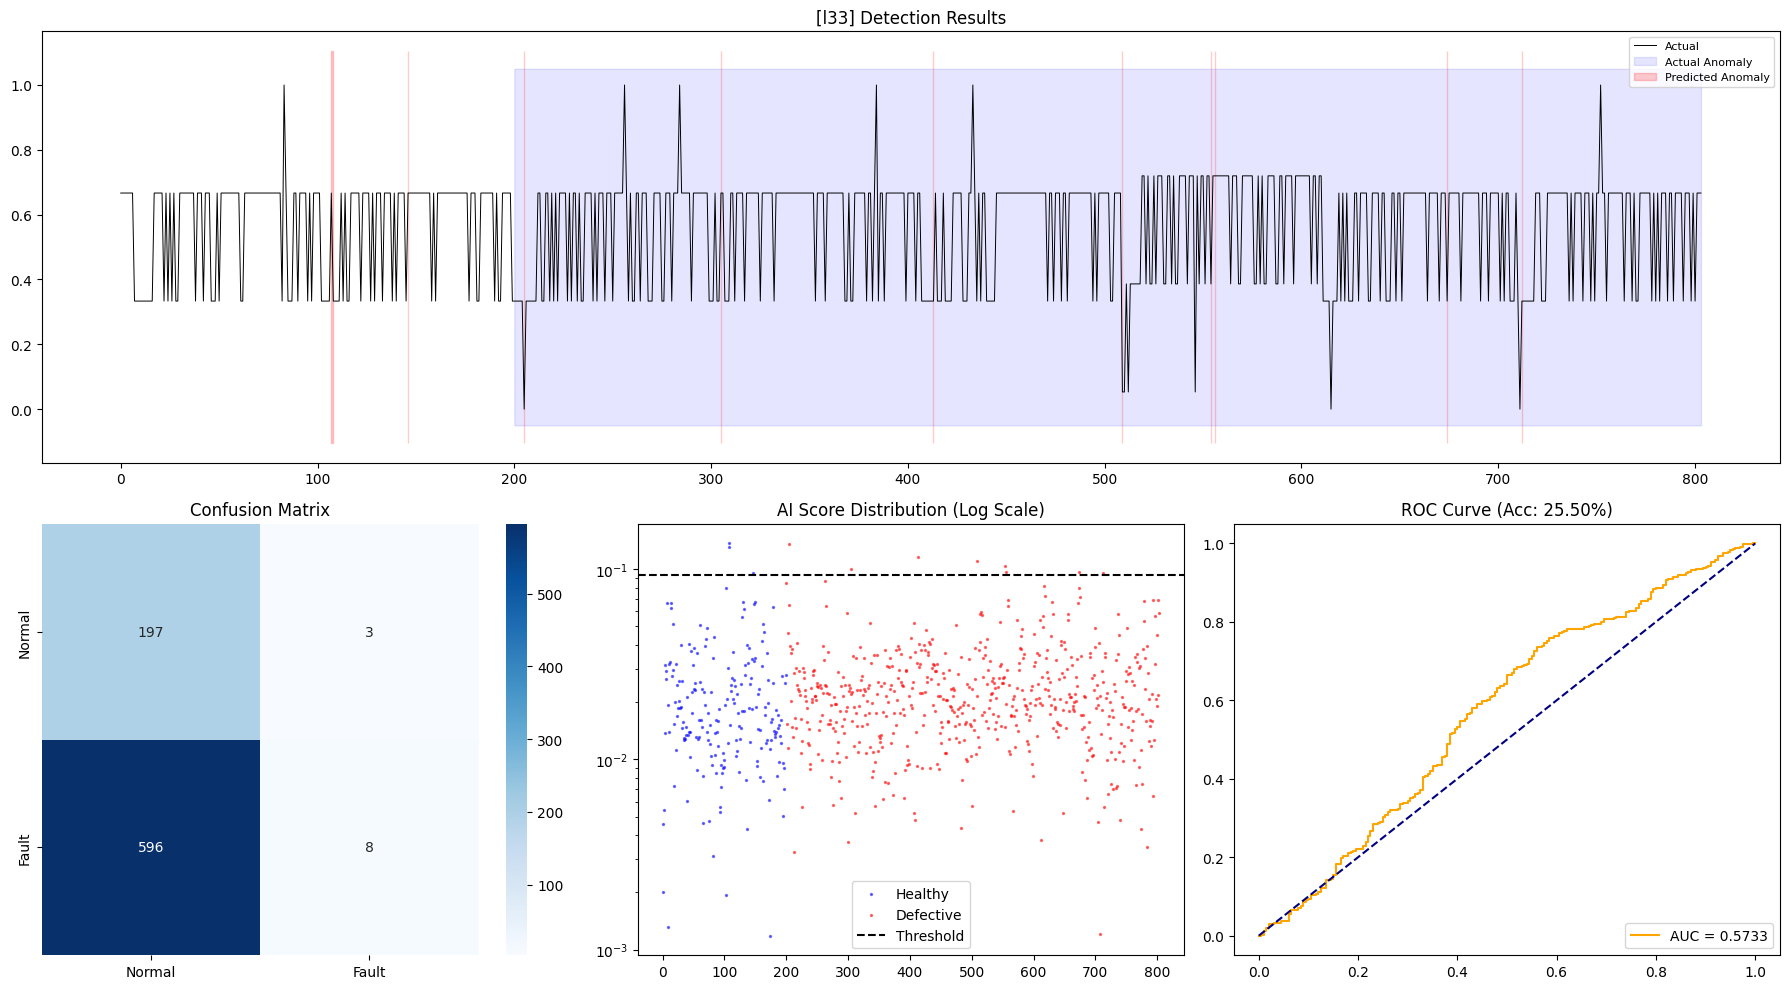

In [ ]:
#6. 통합 시각화(Figure 2, 3, CM, AUC)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_all_results_unified(eid, res):
    mse = res['mse']
    labels = res['labels']
    train_mse = res['train_mse']
    test_data = res['test_data']
    y_pred = res['y_pred']

    threshold = np.percentile(train_mse, 99)
    preds = (mse > threshold).astype(int)

    fig = plt.figure(figsize=(18, 10)) # 전체 크기 최적화
    gs = fig.add_gridspec(2, 3) # 2행 3열로 더 컴팩트하게 구성

    # --- [1] Detection Result (상단) ---
    ax0 = fig.add_subplot(gs[0, :])
    ax0.plot(test_data[:, 0], color='black', label='Actual', lw=0.7)
    ax0.fill_between(range(len(mse)), ax0.get_ylim()[0], ax0.get_ylim()[1],
                     where=labels > 0, color='blue', alpha=0.1, label='Actual Anomaly')
    ax0.fill_between(range(len(mse)), ax0.get_ylim()[0], ax0.get_ylim()[1],
                     where=preds > 0, color='red', alpha=0.2, label='Predicted Anomaly')
    ax0.set_title(f"[{eid}] Detection Results")
    ax0.legend(loc='upper right', fontsize=8)

    # --- [2] Confusion Matrix ---
    ax1 = fig.add_subplot(gs[1, 0])
    if len(np.unique(labels)) > 1:
        cm = confusion_matrix(labels, preds)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax1,
                    xticklabels=['Normal', 'Fault'], yticklabels=['Normal', 'Fault'])
    ax1.set_title("Confusion Matrix")

    # --- [3] AI Score Distribution (로그 스케일 적용) ---
    ax2 = fig.add_subplot(gs[1, 1])
    # [수정] 정상/이상 점수를 명확히 분리해서 시각화
    normal_scores = mse[labels == 0]
    fault_scores = mse[labels == 1]

    if len(normal_scores) > 0:
        ax2.scatter(range(len(normal_scores)), normal_scores, s=2, c='blue', label='Healthy', alpha=0.5)
    if len(fault_scores) > 0:
        ax2.scatter(range(len(normal_scores), len(mse)), fault_scores, s=2, c='red', label='Defective', alpha=0.5)

    ax2.axhline(y=threshold, color='black', linestyle='--', label='Threshold')
    ax2.set_yscale('log') # [핵심] Y축 로그 스케일로 바닥에 붙은 정상치 확인
    ax2.set_title("AI Score Distribution (Log Scale)")
    ax2.legend()

    # --- [4] ROC Curve & Accuracy ---
    ax3 = fig.add_subplot(gs[1, 2])
    if len(np.unique(labels)) > 1:
        fpr, tpr, _ = roc_curve(labels, mse)
        roc_auc = auc(fpr, tpr)
        acc = (preds == labels).mean() * 100
        ax3.plot(fpr, tpr, color='orange', label=f'AUC = {roc_auc:.4f}')
        ax3.plot([0, 1], [0, 1], color='navy', linestyle='--')
        ax3.set_title(f"ROC Curve (Acc: {acc:.2f}%)")
        ax3.legend(loc="lower right")
    else:
        ax3.text(0.5, 0.5, "Need both classes\nfor ROC/AUC", ha='center')

    plt.tight_layout()
    plt.show()

 #모든 실험 결과 출력 루프
for eid, res in results_data.items():
    plot_all_results_unified(eid, res)